# Groceries dataset

Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

Association Rules are widely used to analyze retail basket or transaction data and are intended to identify strong rules discovered in transaction data using measures of interestingness, based on the concept of strong rules.

# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

# Loading Groceries dataset

In [2]:
basket = pd.read_csv("/kaggle/input/groceries-dataset/Groceries_dataset.csv")
basket.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


# Data Preprocessing & EDA

In [3]:
#Check for NULL values
basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [4]:
# Calculating number of transactions 
transactions = basket.groupby(['Member_number', 'Date'])
transactions.count()

itemDescription
Member_number Date                       
1000          15-03-2015                4
              24-06-2014                3
              24-07-2015                2
              25-11-2015                2
              27-05-2015                2
...                                   ...
4999          24-01-2015                6
              26-12-2015                2
5000          09-03-2014                2
              10-02-2015                3
              16-11-2014                2

[14963 rows x 1 columns]

In [5]:
#Calculating total number of products sold
basket["itemDescription"].value_counts().head(10)

whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: itemDescription, dtype: int64

In [6]:
#Calculating support of each item
support = (basket['itemDescription'].value_counts()/14963*100)
support.head()

whole milk          16.721246
other vegetables    12.684622
rolls/buns          11.468288
soda                10.118292
yogurt               8.915324
Name: itemDescription, dtype: float64

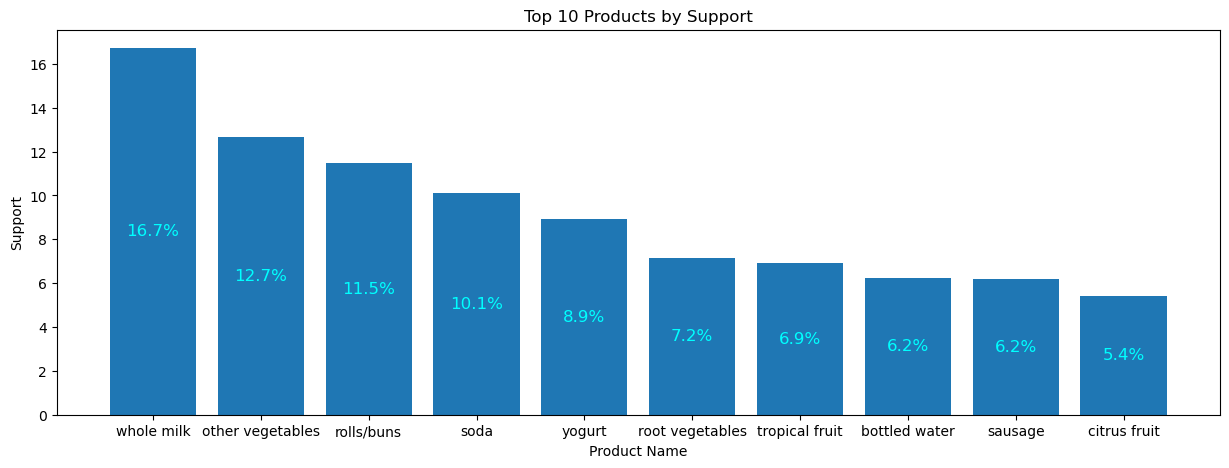

In [7]:
# Plotting support of Top 10 Items
plt.figure(figsize = (15,5))
bars = plt.bar(x = np.arange(len(support.head(10))), height = (support).head(10))
plt.bar_label(bars, fontsize=12, color='cyan', fmt = '%2.1f%%', label_type = 'center')
plt.xticks(ticks = np.arange(len(support.head(10))), labels = support.index[:10])

plt.title('Top 10 Products by Support')
plt.ylabel('Support')
plt.xlabel('Product Name')
plt.show()

In [8]:
#Grouping into transactions
basket.itemDescription = basket.itemDescription.transform(lambda x: [x])
basket = basket.groupby(['Member_number','Date']).sum()['itemDescription'].reset_index(drop=True)

encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(basket).transform(basket), columns=encoder.columns_)
display(transactions.head())

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Apriori and Association Rules

* The Apriori Algorithm will be used to generate frequent item sets. We will be specifying the minimum support to be 6 out of total transactions.The association rules are generated and we filter for Lift value > 1.5

In [9]:
frequent_itemsets = apriori(transactions, min_support= 6/len(basket), use_colnames=True, max_len = 2)
rules = association_rules(frequent_itemsets, metric="lift",  min_threshold = 1.5)
display(rules.head())
print("Rules identified: ", len(rules))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(UHT-milk),(butter milk),0.021386,0.017577,0.000601,0.028125,1.600131,0.000226,1.010854,0.383247
1,(butter milk),(UHT-milk),0.017577,0.021386,0.000601,0.034221,1.600131,0.000226,1.013289,0.381761
2,(cream cheese ),(UHT-milk),0.023658,0.021386,0.000869,0.036723,1.717152,0.000363,1.015922,0.427761
3,(UHT-milk),(cream cheese ),0.021386,0.023658,0.000869,0.040625,1.717152,0.000363,1.017685,0.426767
4,(artif. sweetener),(soda),0.001938,0.097106,0.000468,0.241379,2.485725,0.000280,1.190178,0.598864


Rules identified:  190


# Visualizations

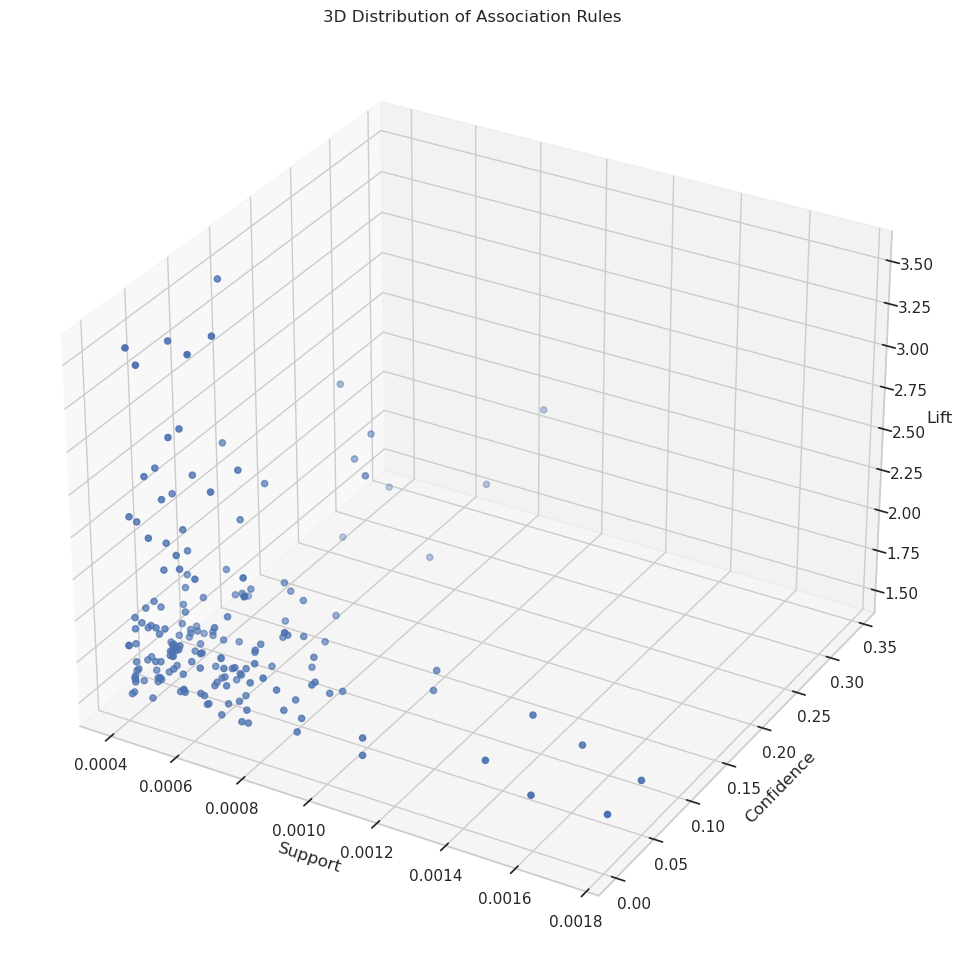

In [10]:
sns.set(style = "whitegrid")
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection = '3d')


x = rules['support']
y = rules['confidence']
z = rules['lift']

ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_zlabel("Lift")

ax.scatter(x, y, z)
ax.set_title("3D Distribution of Association Rules")

plt.show()

<>:27: DeprecationWarning: invalid escape sequence \d
<>:27: DeprecationWarning: invalid escape sequence \d
<>:27: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_19/3067535388.py:27: DeprecationWarning: invalid escape sequence \d
  if re.compile("^[R]\d+$").fullmatch(node) != None:


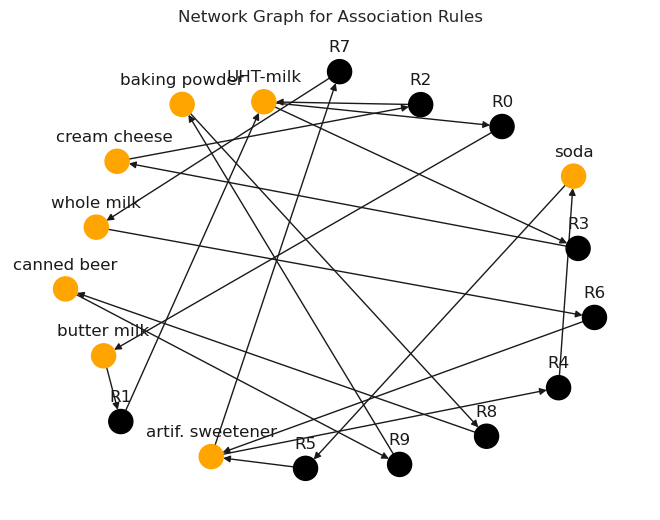

In [11]:
import warnings
warnings.filterwarnings(action='ignore')

def draw_network(rules, rules_to_show):
  # Directional Graph from NetworkX
  network = nx.DiGraph()
  
  # Loop through number of rules to show
  for i in range(rules_to_show):
    
    # Add a Rule Node
    network.add_nodes_from(["R"+str(i)])
    for antecedents in rules.iloc[i]['antecedents']: 
        # Add antecedent node and link to rule
        network.add_nodes_from([antecedents])
        network.add_edge(antecedents, "R"+str(i),  weight = 2)
      
    for consequents in rules.iloc[i]['consequents']:
        # Add consequent node and link to rule
        network.add_nodes_from([consequents])
        network.add_edge("R"+str(i), consequents,  weight = 2)

  color_map=[]  
  
  # For every node, if it's a rule, colour as Black, otherwise Orange
  for node in network:
       if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append('black')
       else:
            color_map.append('orange')
  
  # Position nodes using spring layout
  pos = nx.spring_layout(network, k=16, scale=1)
  # Draw the network graph
  nx.draw(network, pos, node_color = color_map, font_size=8)            
  
  # Shift the text position upwards
  for p in pos:  
      pos[p][1] += 0.12

  nx.draw_networkx_labels(network, pos)
  plt.title("Network Graph for Association Rules")
  plt.show()

draw_network(rules, 10)


# Business Application

Let’s say the grocery has bought up too much Whole Milk and is now worrying that the stocks will expire if they cannot be sold out in time. To make matters worse, the profit margin of Whole Milk is so low that they cannot afford to have a promotional discount without killing too much of their profits.


One approach that can be proposed is to find out which products drive the sales of Whole Milk and offer discounts on those products instead.

In [12]:
milk_rules = rules[rules['consequents'].astype(str).str.contains('whole milk')]
milk_rules = milk_rules.sort_values(by=['lift'],ascending = [False]).reset_index(drop = True)

milk_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(brandy),(whole milk),0.002540,0.157923,0.000869,0.342105,2.166281,0.000468,1.279957,0.539750
1,(softener),(whole milk),0.002740,0.157923,0.000802,0.292683,1.853328,0.000369,1.190523,0.461695
2,(canned fruit),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908,0.447899
3,(syrup),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908,0.447899
4,(artif. sweetener),(whole milk),0.001938,0.157923,0.000535,0.275862,1.746815,0.000229,1.162868,0.428360


For instance, we can apply a promotional discount on Brandy, Softener, Canned Fruit, Syrup and Artificial Sweetener. Some of the associations may seem counter-intuitive, but the rules state that these products do drive the sales of Whole Milk.